<a href="https://colab.research.google.com/github/eugenie-kim012/kaggles/blob/main/Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction

*   List item
*   List item


Titanic Top 4% with ensemble modeling
https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [126]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

#2. Load and check data
##2.1 Load data

In [127]:
#Load data
#### Load train and test set

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test['PassengerId']

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2.2 Outlier detection

In [129]:
# Outlier detection: Tukey's IQR method를 기반으로 이상치 다중 탐지 함수 정의
def detect_outliers(df, n, features):
    """
    df: 입력 데이터프레임
    n: 이상치가 n개 초과인 관측치만 반환
    features: 이상치를 탐지할 대상 컬럼 리스트

    각 feature에 대해 Tukey의 IQR 기준으로 이상치를 찾고,
    이상치에 여러 번 포함된 관측치를 반환합니다.
    """

    outlier_indices = []  # 이상치의 인덱스를 누적 저장할 리스트

    # 각 컬럼(특성)마다 반복
    for col in features:
        # 1사분위수 (25% 지점 값)
        Q1 = np.percentile(df[col], 25)

        # 3사분위수 (75% 지점 값)
        Q3 = np.percentile(df[col], 75)

        # IQR (Interquartile Range): Q3 - Q1
        IQR = Q3 - Q1

        # 이상치 기준 범위 설정: IQR의 1.5배 이상 벗어난 값
        outlier_step = 1.5 * IQR

        # 해당 컬럼에서 이상치 조건에 해당하는 인덱스를 추출
        outlier_list_col = df[(df[col] < Q1 - outlier_step) |
                              (df[col] > Q3 + outlier_step)].index

        # 해당 컬럼의 이상치 인덱스를 전체 이상치 목록에 추가
        outlier_indices.extend(outlier_list_col)

    # 이상치 인덱스를 카운트하여, 여러 번 이상치로 등장한 인덱스 찾기
    outlier_indices = Counter(outlier_indices)

    # 이상치로 n번 초과 등장한 관측치만 최종 리스트로 추출
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers  # 이상치로 간주할 인덱스 리스트 반환

# Age, SibSp, Parch, Fare 컬럼에서 이상치가 2개 초과인 관측치를 탐지
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

| 코드                                   | 의미                   |
| ------------------------------------ | -------------------- |
| `train.loc[Outliers_to_drop]`        | 이상치로 간주된 행들을 확인      |
| `train.drop(index=Outliers_to_drop)` | 이상치를 제거한 새 데이터프레임 생성 |


In [130]:
train.loc[Outliers_to_drop] #showing the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [131]:
# drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 2.3 Joining train and test set

In [132]:
## Join train and test datasets in order to obtain the same number of feactures during categories
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# 2.4 Check for null and missing values

In [133]:
#Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)
#Check for Null values
dataset.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,256
SibSp,0
Parch,0
Ticket,0
Fare,1


Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)

In [134]:
#infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,170
SibSp,0
Parch,0
Ticket,0
Fare,0


In [135]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
train.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [137]:
##summarise data
# summarise and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis
## 3.1. Numerical Values

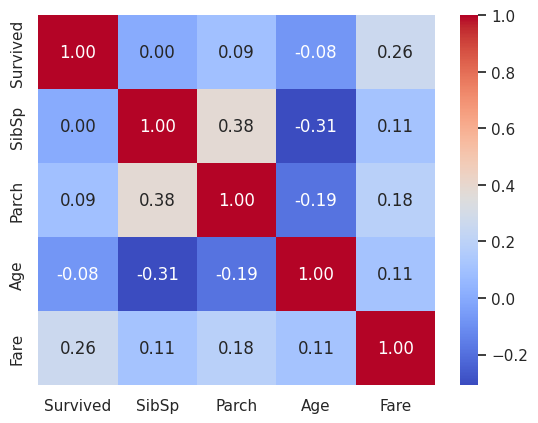

In [138]:
# correlation matrix between numberical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt = '.2f', cmap = "coolwarm")
# only fare seems to have a significative correlation with the survival probabilty

<ipython-input-139-5fb7c4667ae8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")


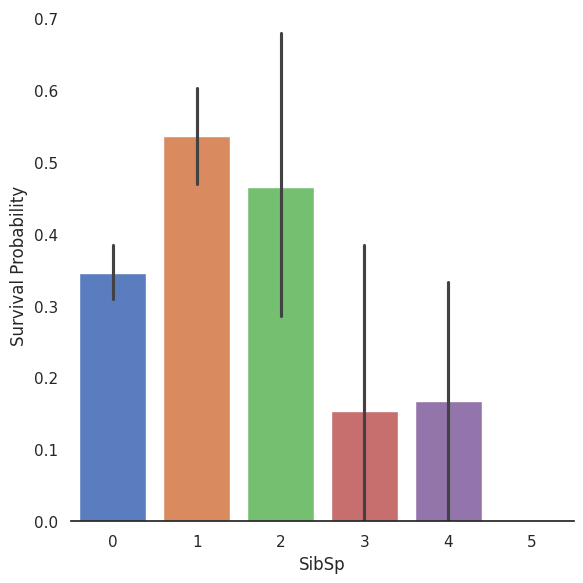

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# 최신 버전 호환: factorplot → catplot
g = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height=6, palette="muted")

# 축 정리 및 라벨 추가
g.despine(left=True)
g.set_ylabels("Survival Probability")

plt.show()


It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

<ipython-input-140-c4dfcb30aff9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette="muted")


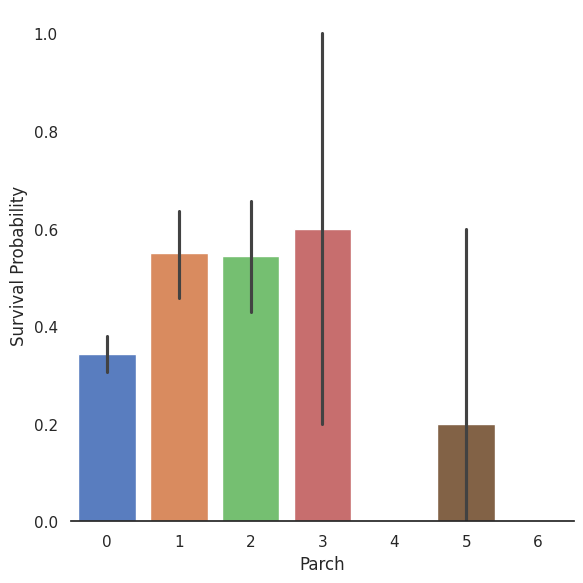

In [140]:
#Explore Parch feacture vs Survived
g = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g.set_ylabels("Survival Probability")
plt.show()

## Age


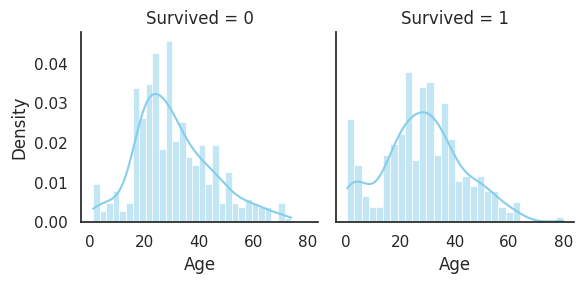

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Age 분포를 Survived=0 / 1로 나눠 시각화 (히스토그램 + KDE 곡선 포함)
g = sns.FacetGrid(train, col='Survived')
g.map(sns.histplot, 'Age', kde=True, stat="density", bins=30, color='skyblue')

plt.show()


| 구버전                           | 신버전                           |
| ----------------------------- | ----------------------------- |
| `sns.distplot()`              | ❌ 사용 중단됨                      |
| `sns.histplot()` + `kde=True` | ✅ 권장 방식 (히스토그램 + 밀도 추정 곡선 포함) |
| `stat="density"`              | Y축을 비율(확률 밀도)로 표시             |
| `bins=30`                     | 구간 수 조절                       |



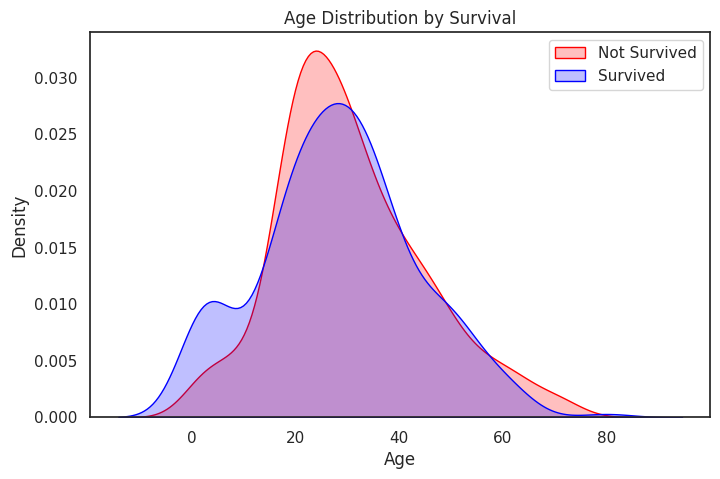

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# 생존 여부에 따른 나이 분포 비교 (KDE 밀도 곡선 시각화)
plt.figure(figsize=(8, 5))

# 사망자 (Survived=0)
sns.kdeplot(
    data=train[train["Survived"] == 0],
    x="Age",
    fill=True,           # shade=True → fill=True 로 변경
    color="red",
    label="Not Survived"
)

# 생존자 (Survived=1)
sns.kdeplot(
    data=train[train["Survived"] == 1],
    x="Age",
    fill=True,
    color="blue",
    label="Survived"
)

# 그래프 레이블 설정
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.title("Age Distribution by Survival")

plt.show()


In [143]:
dataset["Fare"].isnull().sum()

np.int64(1)

In [144]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

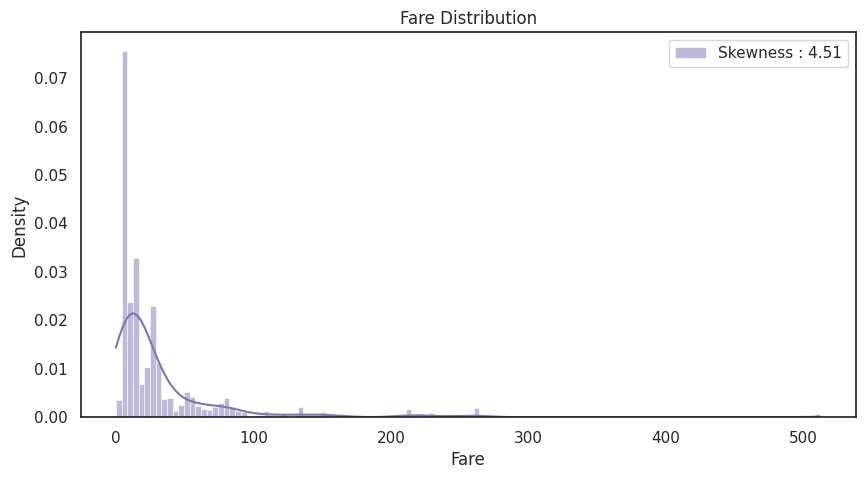

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10, 5))

# KDE + 히스토그램 같이 그리기
sns.histplot(dataset["Fare"], kde=True, stat="density", color="m", label="Skewness : %.2f" % dataset["Fare"].skew())

# 축, 범례 설정
plt.xlabel("Fare")
plt.ylabel("Density")
plt.legend(loc="best")
plt.title("Fare Distribution")

plt.show()


| 요소                                                 | 의미                   | 예시 또는 설명                                    |
| -------------------------------------------------- | -------------------- | ------------------------------------------- |
| `sns.histplot(...)`                                | Seaborn의 히스토그램 함수    | 히스토그램(빈도 막대 그래프) 생성                         |
| `dataset["Fare"]`                                  | 시각화할 대상 데이터 시리즈      | `Fare` 열 (승객 요금)                            |
| `kde=True`                                         | KDE 커널 밀도 곡선을 함께 그림  | → 부드러운 선 그래프가 덧붙음                           |
| `stat="density"`                                   | y축을 밀도(확률 분포 비율)로 표시 | 막대 높이 총합 = 1 (정규화됨)                         |
| `color="m"`                                        | 색상 지정                | `'m'` = magenta (자홍색)                       |
| `label="Skewness : %.2f" % dataset["Fare"].skew()` | 범례 라벨 텍스트 지정         | `skew()`는 왜도 계산 함수 (`%.2f`로 소수점 둘째 자리까지 표시) |


이 코드를 쓰는 이유
Fare 분포가 한쪽으로 치우쳐져(skewed) 있는지를 시각화로 확인하고,

KDE 곡선을 통해 분포의 연속적인 흐름도 함께 표현하며,

Skewness 값을 범례로 직접 표시해 해석을 도와줍니다.



In [146]:
#apply log to fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)


<ipython-input-147-35ec8efd2ddc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))


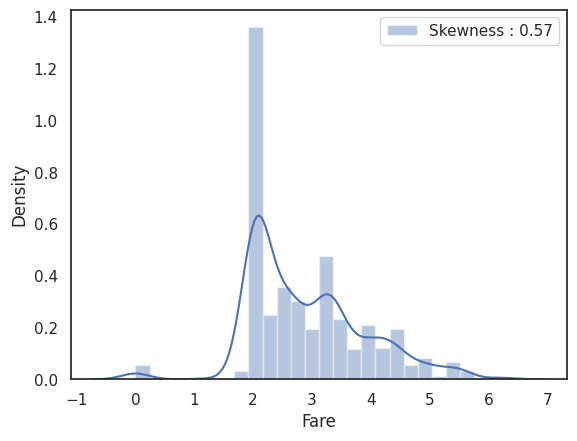

In [147]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# 3.2. Categorical values
## Sex

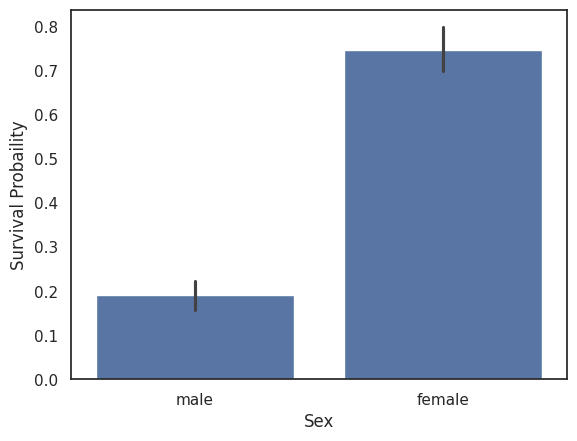

In [148]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("Survival Probaility")

In [149]:
train[["Sex", "Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


## Pclass

<ipython-input-150-fabe4e4a5a2d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


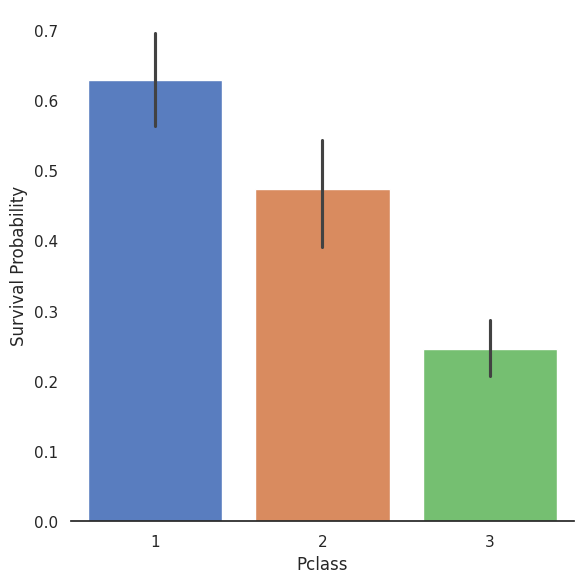

In [150]:
g = sns.catplot(
    x="Pclass",
    y="Survived",
    data=train,
    kind="bar",
    height=6,
    palette="muted"
)

g.despine(left=True)
g.set_ylabels("Survival Probability")
plt.show()

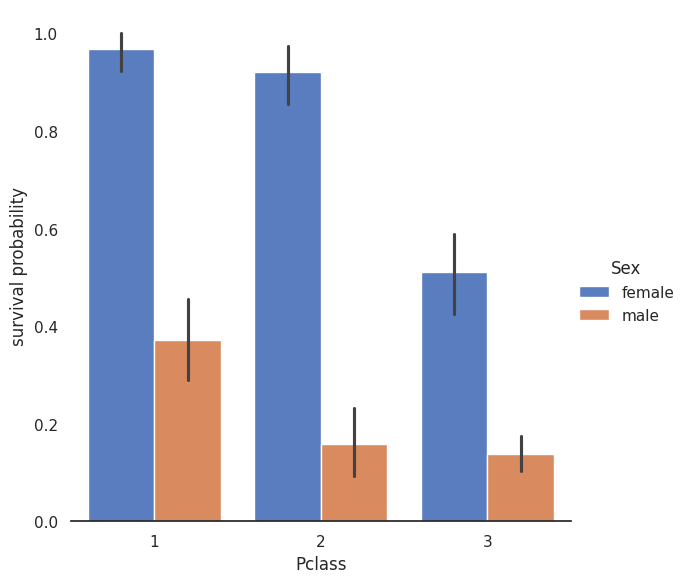

In [151]:
#explore pclass vs survived by sex


g = sns.catplot(
    x="Pclass",
    y="Survived",
    hue="Sex",
    data=train,
    kind="bar",
    height=6,
    palette="muted"
)

g.despine(left=True)
g = g.set_ylabels("survival probability")

# Embarked

In [152]:
dataset["Embarked"].isnull().sum()

np.int64(2)

In [153]:
#Fill embarked nan value of dataset set with S most frequent value
dataset["Embarked"]=dataset["Embarked"].fillna("S")

<ipython-input-154-bb5834252ae9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


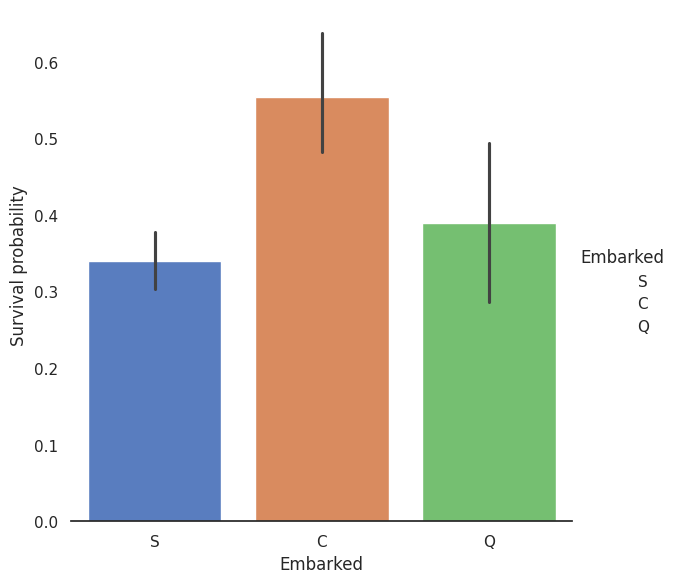

In [154]:
#Explore Embarked vs Survived


g = sns.catplot(
    x="Embarked",
    y="Survived",
    data=train,
    kind="bar",
    height=6,
    palette="muted"
)

g.despine(left=True)
g = g.set_ylabels("Survival probability")

<ipython-input-155-f2075355e4bb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


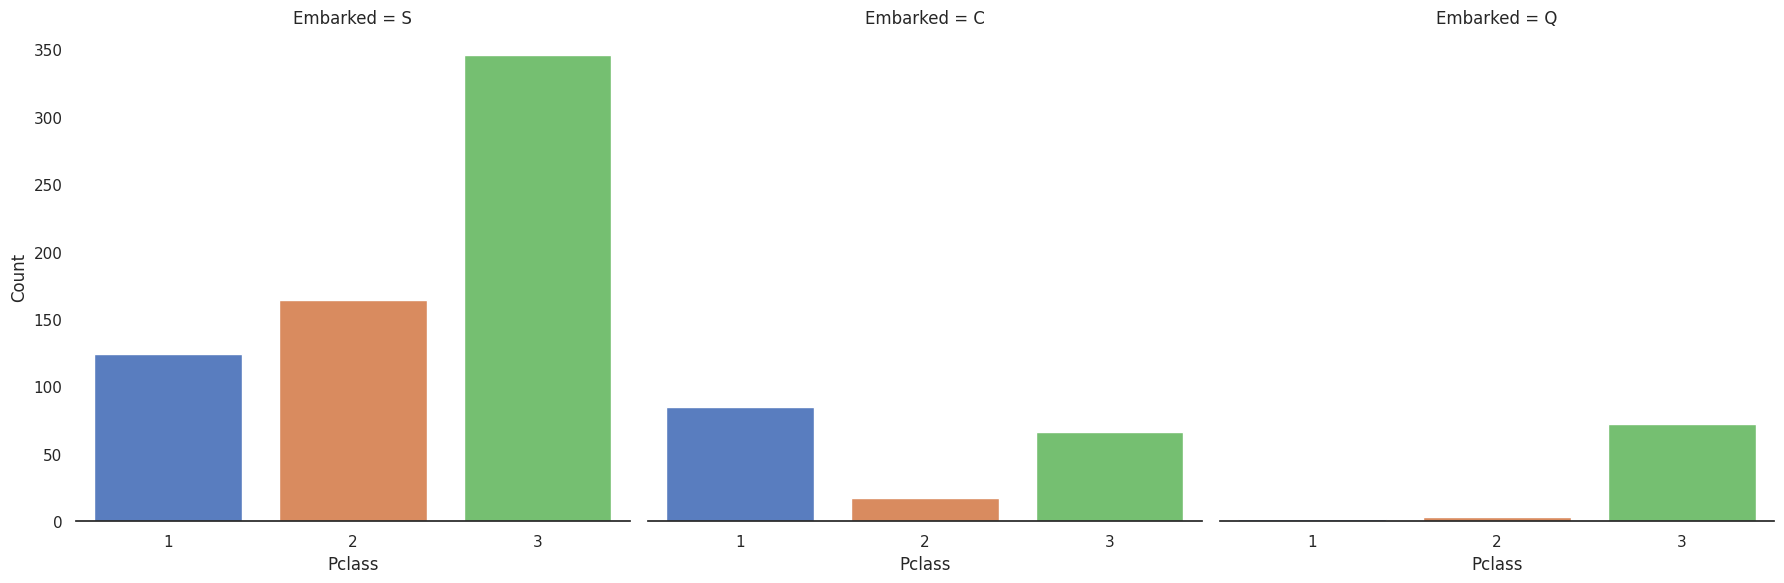

In [155]:
# Pclass별 탑승항구별 승객 수 시각화
g = sns.catplot(
    x="Pclass",
    col="Embarked",
    data=train,
    kind="count",
    height=6,
    palette="muted"
)

g.despine(left=True)
g = g.set_ylabels("Count")


# Filling missing Values

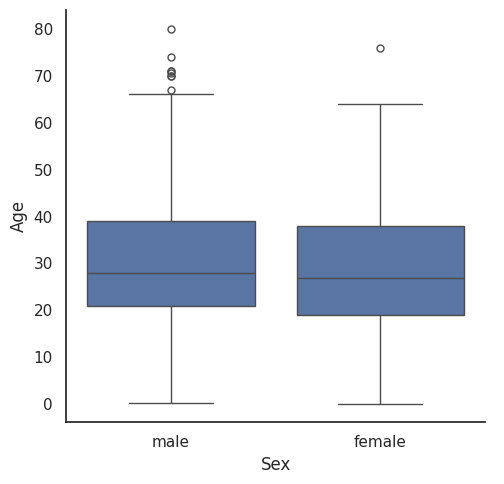

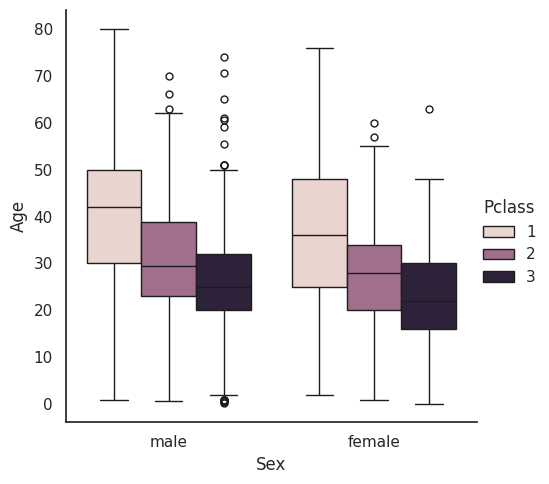

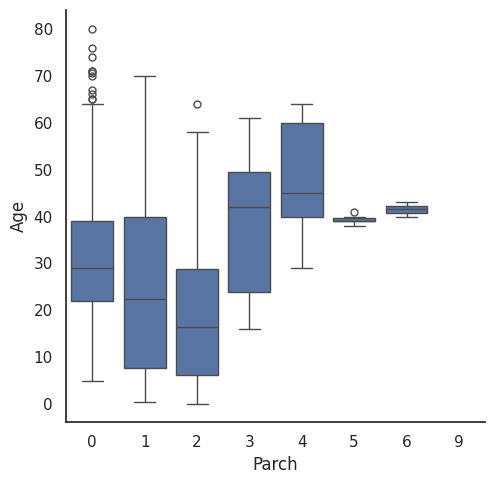

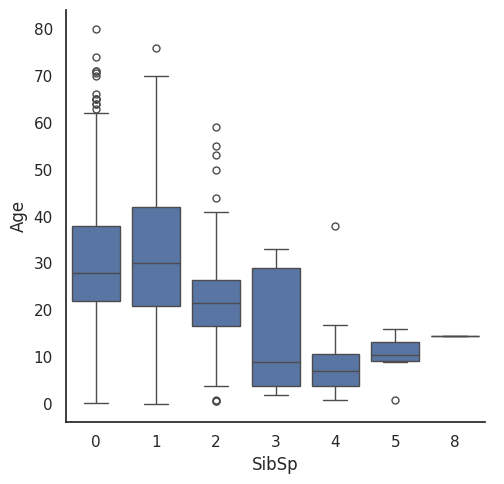

In [156]:
g=sns.catplot(y="Age", x="Sex", data=dataset, kind="box")
g=sns.catplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g=sns.catplot(y="Age", x="Parch", data=dataset, kind="box")
g=sns.catplot(y="Age", x="SibSp", data=dataset, kind="box")


In [157]:
#convert sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male":0, "female":1})

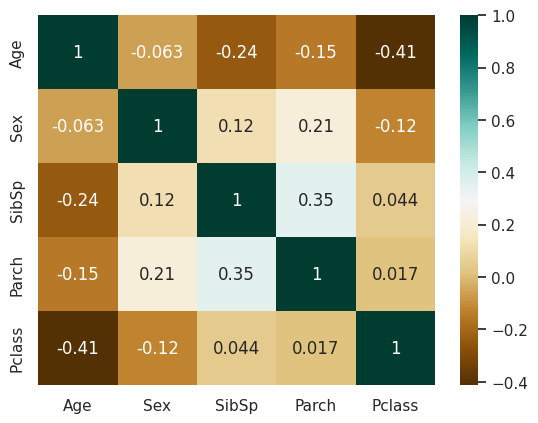

In [158]:
g=sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(),cmap="BrBG",annot=True)

In [159]:
#filling missing value of Age

#Fill age with the median age of similiar tows according to Pcalss, Parch and SibSp
# Index of NaN age rows

#NaN이 있는 인덱스를 찾기
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    #비슷한 그룹을 기준으로 중앙값 계산
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["Pclass"])
    & (dataset['Parch'] == dataset.iloc[i]["Parch"])
    & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()

    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

<ipython-input-159-a7342000b85d>:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['Age'].iloc[i] = age_pred
<ipython-input-159-a7342000b85d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

<ipython-input-160-e6c3a3cd1ee2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
<ipython-input-160-e6c3a3cd1ee2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


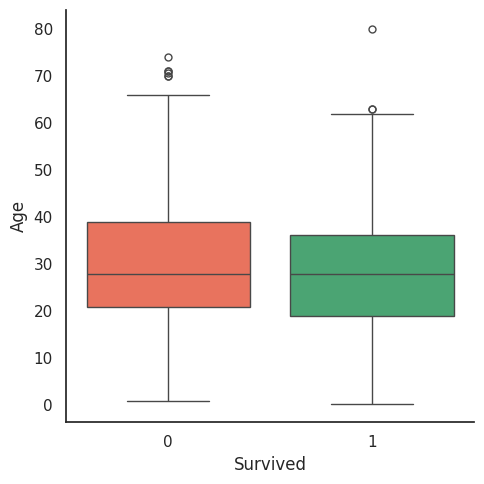

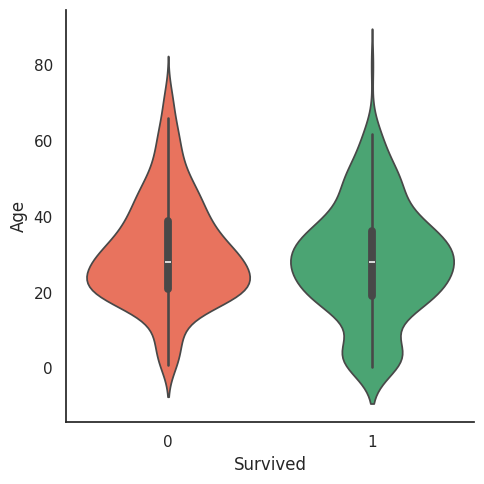

In [160]:
g = sns.catplot(
    x="Survived",
    y="Age",
    data=train,
    kind="box",
    palette={"0": "tomato", "1": "mediumseagreen"}
)

g = sns.catplot(
    x="Survived",
    y="Age",
    data=train,
    kind="violin",
    palette={"0": "tomato", "1": "mediumseagreen"}
)

#5. Feacture Engineering
## 5.1. Name/ Title

In [161]:
dataset["Name"].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [162]:
#Get title from name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

,Title
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


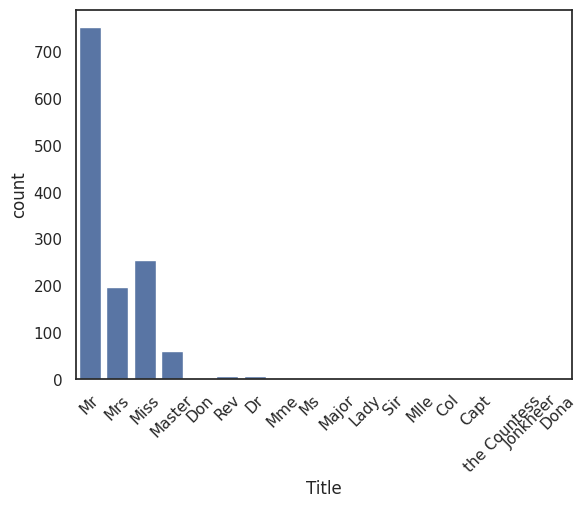

In [163]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [164]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

<ipython-input-165-37c2d48ec0d7>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])


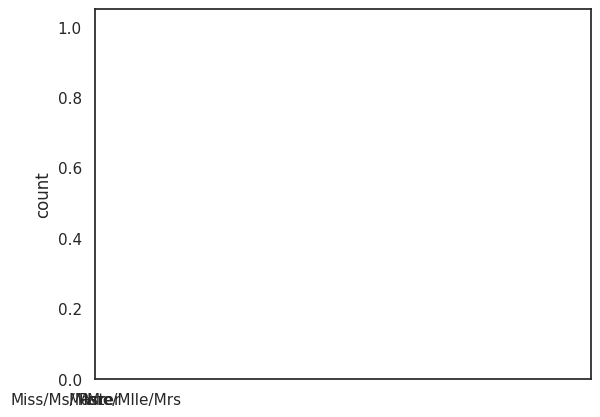

In [165]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

<ipython-input-166-1e9ea1afc9ef>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


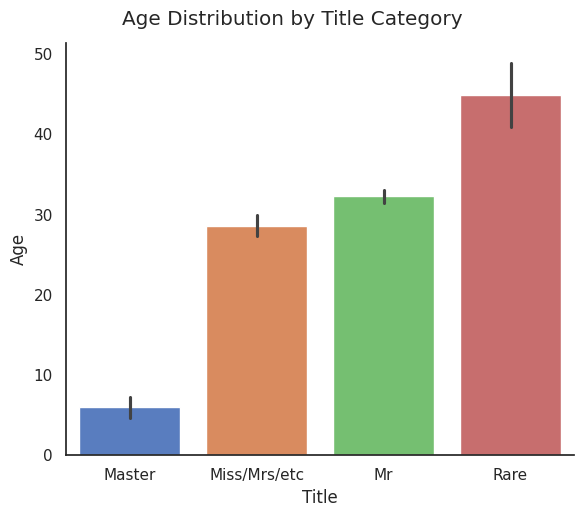

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. 이름에서 Title 추출
dataset["Title"] = dataset["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

# 2. 희귀 타이틀 통합
dataset["Title"] = dataset["Title"].replace(
    ['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major',
     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare'
)

# 3. 타이틀 숫자 인코딩
title_mapping = {
    "Master": 0,
    "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1,
    "Mr": 2,
    "Rare": 3
}
dataset["Title"] = dataset["Title"].map(title_mapping)

# 4. 매핑되지 않은 값은 'Rare'(3)으로 채움
dataset["Title"] = dataset["Title"].fillna(3).astype(int)

# 5. 시각화
g = sns.catplot(
    x="Title", y="Age",
    data=dataset,
    kind="bar",
    height=5, aspect=1.2,
    palette="muted"
)

# 6. x축 tick 값 고정 + 레이블 설정
g.ax.xaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3]))
g.ax.set_xticklabels(["Master", "Miss/Mrs/etc", "Mr", "Rare"])

# 7. 제목 추가
g.fig.suptitle("Age Distribution by Title Category", y=1.03)

plt.show()

<ipython-input-167-35040ba4e5a7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Title", y="Survived", data=dataset,kind="bar", height=5, palette="muted")
<ipython-input-167-35040ba4e5a7>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])


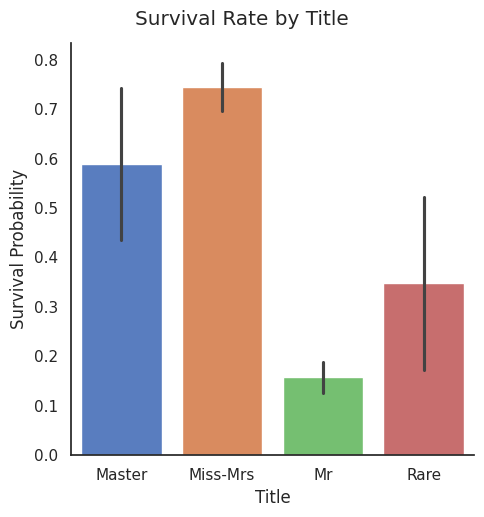

In [167]:
g = sns.catplot(x="Title", y="Survived", data=dataset,kind="bar", height=5, palette="muted")
g.ax.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g.set_ylabels("Survival Probability")
g.fig.suptitle("Survival Rate by Title", y=1.03)
plt.show()

In [169]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [170]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

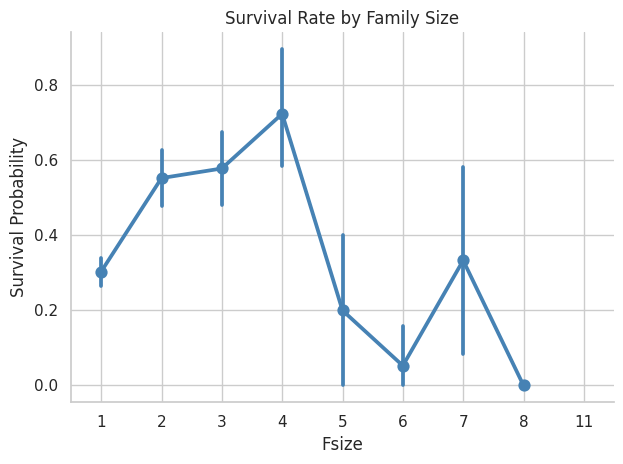

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Seaborn 스타일 적용 (classic seaborn 느낌)
sns.set(style="whitegrid")

# 정확한 꺾은선 + 오차막대 그래프
g = sns.pointplot(
    x="Fsize",
    y="Survived",
    data=dataset,
    errorbar='ci',        # Seaborn 0.12+ 기준 (기존 ci=95 대체)
    marker='o',
    linestyle='-',

    color='steelblue'
)

# 제목과 축 레이블
g.set_title("Survival Rate by Family Size")
g.set_xlabel("Fsize")
g.set_ylabel("Survival Probability")

# grid 다시 켜기# grid 다시 켜기
sns.despine()  # spine만 제거하고 grid는 유지
plt.grid(True)

# 보기 좋은 배치
plt.tight_layout()
plt.show()


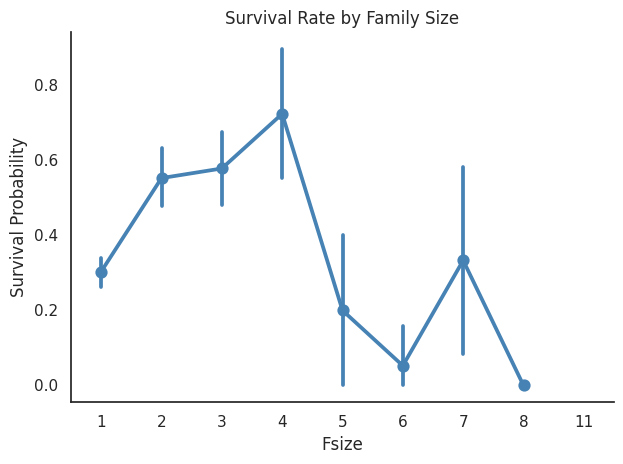

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")  # 👉 y축 그리드 없음

g = sns.pointplot(
    x="Fsize",
    y="Survived",
    data=dataset,
    errorbar='ci',
    marker='o',
    linestyle='-',
    color='steelblue'
)

g.set_title("Survival Rate by Family Size")
g.set_xlabel("Fsize")
g.set_ylabel("Survival Probability")

sns.despine()
plt.grid(axis='y', visible=False)  # 👉 y축 그리드 제거
plt.tight_layout()
plt.show()


In [186]:
#create new feacture of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >= 5 else 0)

<ipython-input-189-60d7de711757>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Single", y="Survived", data=dataset, ax=axes[0, 0], palette="muted")
<ipython-input-189-60d7de711757>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="SmallF", y="Survived", data=dataset, ax=axes[0, 1], palette="muted")
<ipython-input-189-60d7de711757>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MedF", y="Survived", data=dataset, ax=axes[1, 0], palette="muted")
<ipython-input-189-60d7de711757>:18: FutureWarning: 

Passing `palette` without assig

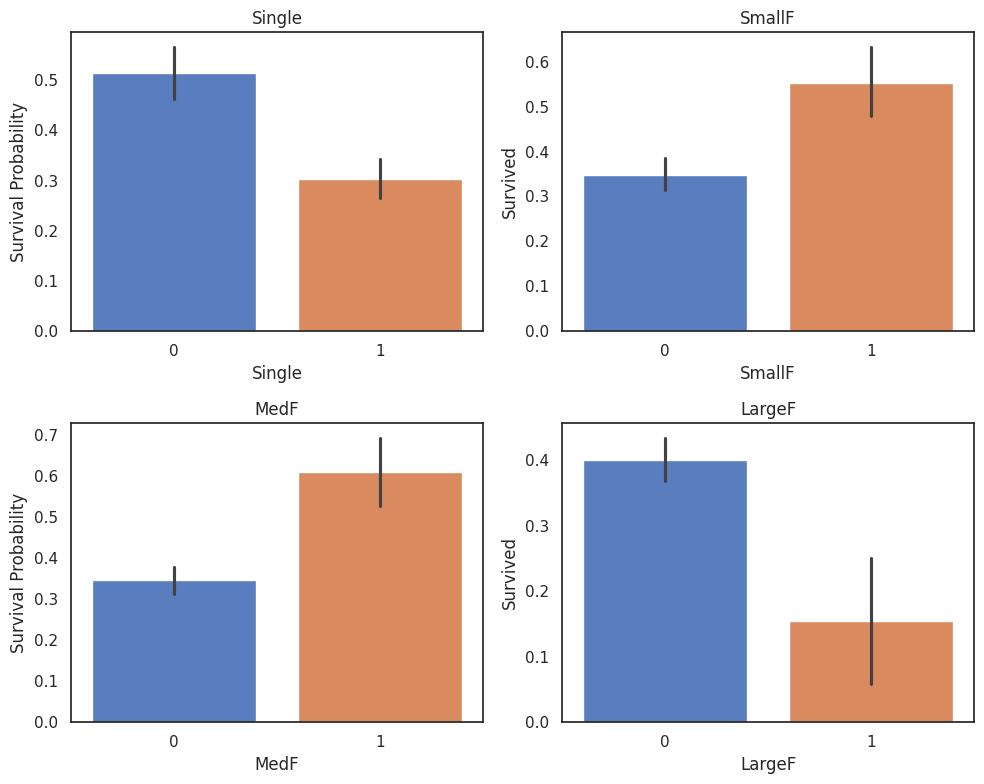

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 각 subplot에 개별 barplot 그리기
sns.barplot(x="Single", y="Survived", data=dataset, ax=axes[0, 0], palette="muted")
axes[0, 0].set_title("Single")
axes[0, 0].set_ylabel("Survival Probability")

sns.barplot(x="SmallF", y="Survived", data=dataset, ax=axes[0, 1], palette="muted")
axes[0, 1].set_title("SmallF")

sns.barplot(x="MedF", y="Survived", data=dataset, ax=axes[1, 0], palette="muted")
axes[1, 0].set_title("MedF")
axes[1, 0].set_ylabel("Survival Probability")

sns.barplot(x="LargeF", y="Survived", data=dataset, ax=axes[1, 1], palette="muted")
axes[1, 1].set_title("LargeF")

plt.tight_layout()
plt.show()


In [192]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

KeyError: "None of [Index(['Title'], dtype='object')] are in the [columns]"

In [193]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


In [194]:
dataset["Cabin"].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


In [196]:
dataset["Cabin"].describe()

,Cabin
count,292
unique,186
top,G6
freq,5


In [198]:
dataset["Cabin"].isnull().sum()

np.int64(1007)

In [199]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103


In [205]:
#replace the cabin number by the type of cabin 'x' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

<ipython-input-211-416e99fb7221>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x="Cabin",data=dataset, order=['A','B','C','D','E','F','G','T','X'], palette="muted")


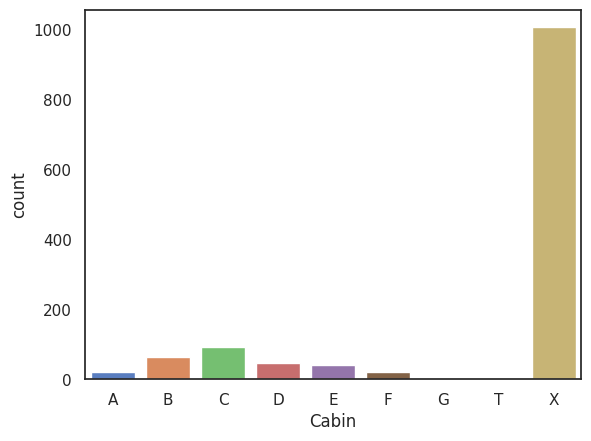

In [211]:
g = sns.countplot(x="Cabin",data=dataset, order=['A','B','C','D','E','F','G','T','X'], palette="muted")

In [212]:
import seaborn as sns

sns.set_palette("muted")  # 이후 모든 plot에 기본 적용됨

<ipython-input-216-3b10f8832452>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'], palette="muted")


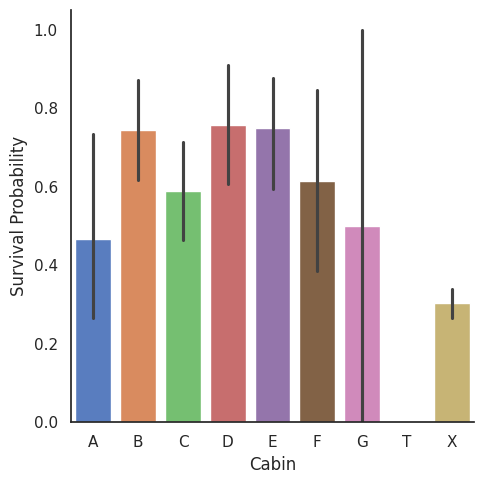

In [216]:
g = sns.catplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'], palette="muted")
g = g.set_ylabels("Survival Probability")

In [218]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

In [219]:
dataset["Ticket"].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


In [221]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #take prefix
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

,Ticket
0,A5
1,PC
2,STONO2
3,X
4,X


In [222]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [223]:
#Create categorical value for Pcalss
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [224]:
#Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [225]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Fsize_str,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,2,0,1,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,2,0,1,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,1,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,2,0,1,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,1,0,...,False,False,False,False,False,False,True,False,False,True


# Modeling

In [227]:
# separating train dataset and test dataset

# 전체 dataset에서 학습용 데이터(train)의 행 개수만큼 앞부분을 추출
train = dataset[:train_len]

# 전체 dataset에서 train_len 이후부터 끝까지를 테스트셋으로 사용
test = dataset[train_len:]

# 테스트셋에는 실제 정답인 'Survived' 컬럼이 존재하면 안 되므로 삭제
# axis=1 → 열 방향 삭제 / inplace=True → 원본 test에 바로 적용
test.drop(labels=["Survived"], axis=1, inplace=True)


<ipython-input-227-de5a6c9f7494>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"], axis=1, inplace=True)


In [229]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

<ipython-input-229-adc05dee1340>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


# 6.1 Simple modeling


In [230]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# 모델링 비교 visualisaiton을 통해 어떤 모델링으로 하이퍼 파라미터를 돌려야 하나 정하는 단계

<ipython-input-234-1e8ede629d1e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


Text(0.5, 1.0, 'Cross Validation Scores')

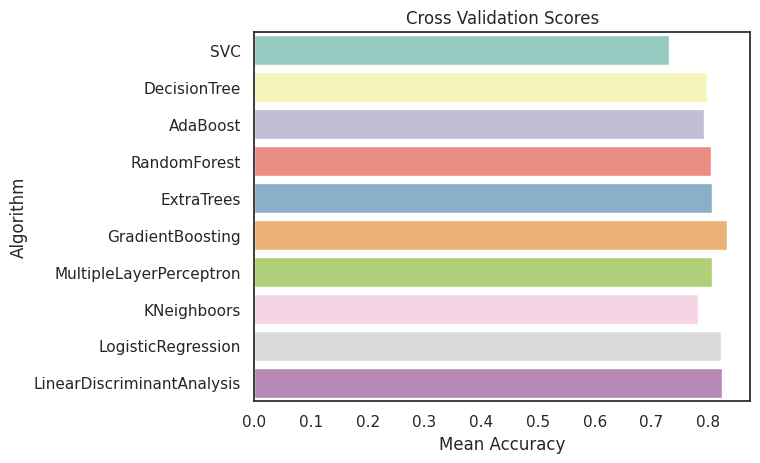

In [234]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(
    x="CrossValMeans",
    y="Algorithm",
    data=cv_res,
    palette="Set3",
    orient="h"
)

g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")


<ipython-input-235-5c2aacdb7078>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


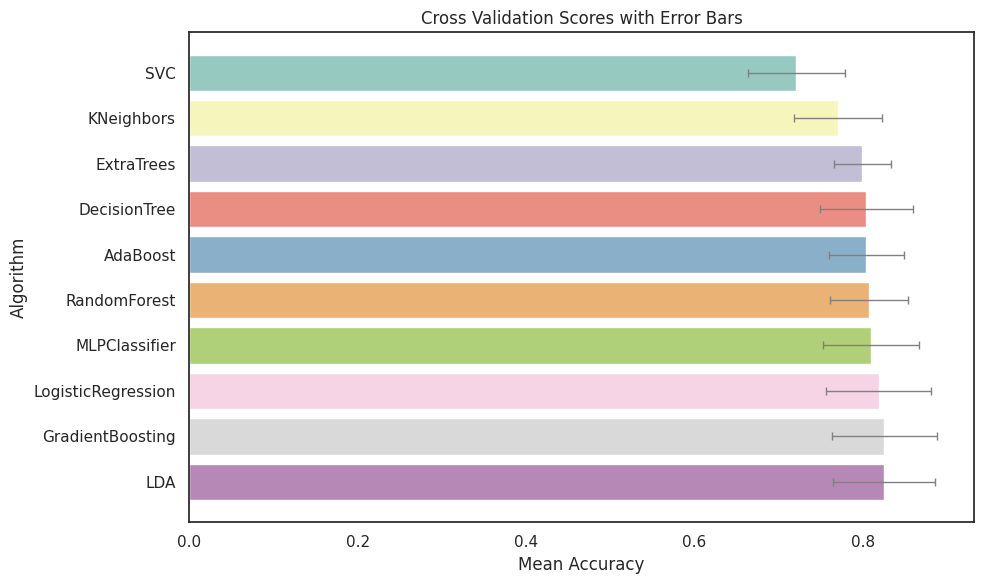

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, RandomForestClassifier,
    ExtraTreesClassifier, GradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# ⚙️ 1. 설정
random_state = 2
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)

# 📦 2. 모델 리스트 정의
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                       random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis()
]

# 🧪 3. 교차검증
cv_results = []
for clf in classifiers:
    score = cross_val_score(clf, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4)
    cv_results.append(score)

# 📊 4. 평균 & 표준편차 저장
cv_means = [result.mean() for result in cv_results]
cv_std = [result.std() for result in cv_results]

# 📋 5. 결과 테이블 생성
cv_res = pd.DataFrame({
    "Algorithm": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
        "GradientBoosting", "MLPClassifier", "KNeighbors", "LogisticRegression", "LDA"
    ],
    "CrossValMeans": cv_means,
    "CrossValerrors": cv_std
})

# 🎨 6. 시각화 (막대 + 오차막대)
cv_res_sorted = cv_res.sort_values(by="CrossValMeans")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="CrossValMeans",
    y="Algorithm",
    data=cv_res_sorted,
    palette="Set3",
    orient="h"
)

# 오차막대 수동 추가
for i, (mean, std) in enumerate(zip(cv_res_sorted["CrossValMeans"], cv_res_sorted["CrossValerrors"])):
    plt.errorbar(
        x=mean,
        y=i,
        xerr=std,
        fmt='none',
        ecolor='gray',
        capsize=3,
        elinewidth=1
    )

# 레이블 & 타이틀
plt.xlabel("Mean Accuracy")
plt.title("Cross Validation Scores with Error Bars")
plt.tight_layout()
plt.show()


In [244]:
## 튜닝 후보 찾기

def recommend_models_for_tuning(cv_res, acc_threshold=0.75, std_threshold=0.07):
    """
    교차검증 결과(cv_res)를 바탕으로 하이퍼파라미터 튜닝에 적합한 모델 추천
    - acc_threshold: 최소 평균 정확도 기준
    - std_threshold: 최대 허용 표준편차 (안정성)
    """
    # 하이퍼파라미터 튜닝 효과가 큰 모델 목록
    tunable_models = {
        "SVC",
        "RandomForest",
        "GradientBoosting",
        "AdaBoost",
        "MLPClassifier"
    }

    # 조건에 맞는 모델 필터링
    filtered = cv_res[
        (cv_res["CrossValMeans"] >= acc_threshold) &
        (cv_res["CrossValerrors"] <= std_threshold)
    ]

    # 튜닝 가치 있는 모델만 추리기
    recommended = filtered[filtered["Algorithm"].isin(tunable_models)]

    return recommended.sort_values(by="CrossValMeans", ascending=False).reset_index(drop=True)


In [245]:
top_models = recommend_models_for_tuning(cv_res)
print(top_models)


          Algorithm  CrossValMeans  CrossValerrors
0  GradientBoosting       0.825166        0.062150
1     MLPClassifier       0.809308        0.056540
2      RandomForest       0.807048        0.046526
3          AdaBoost       0.803639        0.044573


## 6.1.2 Hyperparameter tunning for best models¶

* 보통 위의 visualisation을 기준으로, 세부 하이퍼 파라미터 튜닝을 할 모델을 고르는 기준은 아래와 같음

✅ 1. 성능 우수 + 안정성 (mean + std)
* cv_result.mean()이 높고, cv_result.std()가 낮은 모델 우선 고려
* 정확도는 높은데 표준편차가 크면 → 학습 안정성이 떨어진다는 신호
* cv_res[(cv_res["CrossValMeans"] > 0.82) & (cv_res["CrossValerrors"] < 0.02)]

✅ 2. 모델의 확장성 / 하이퍼파라미터 민감도
하이퍼파라미터 조정으로 성능이 크게 향상될 여지가 있는 모델이 좋음



👉 GradientBoosting / SVC / RandomForest는 튜닝 후 성능 향상 가능성이 큼

✅ 3. 트레이드오프 고려: 학습 시간 vs 성능
SVC, MLPClassifier는 튜닝 시간이 길 수 있음

학습 속도 빠르고 튜닝이 효율적인 모델을 먼저 시도

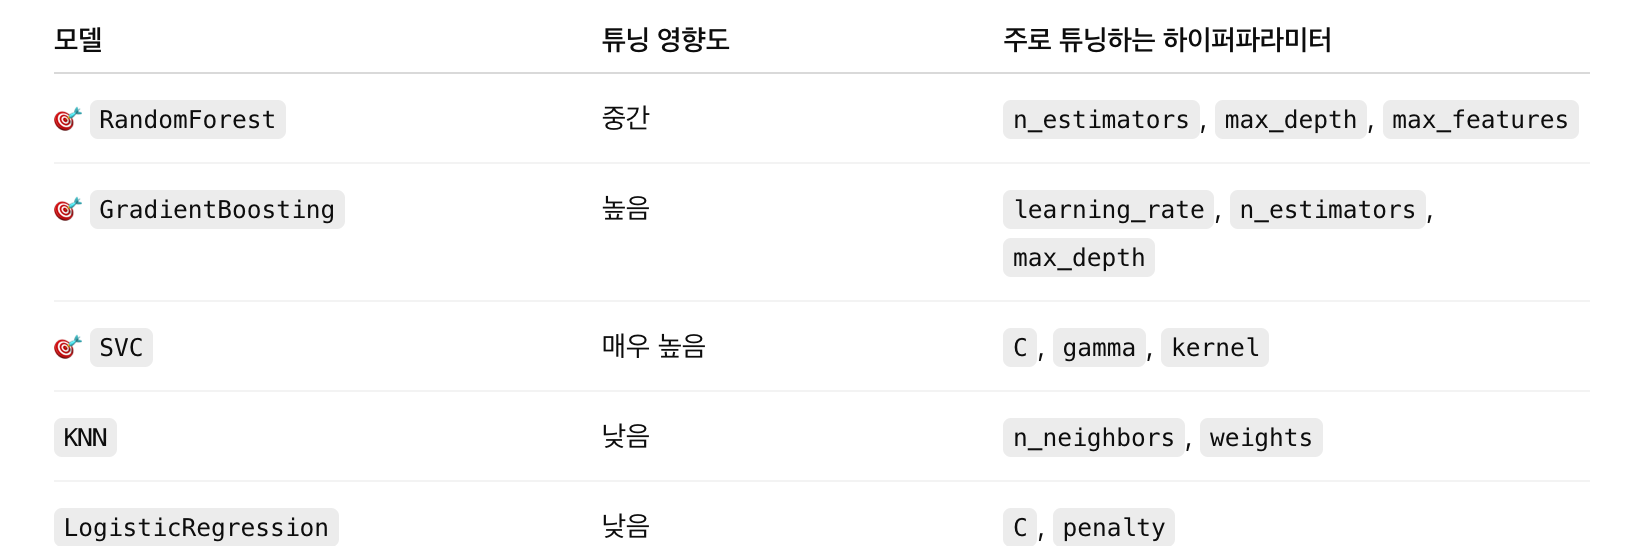

✅ 4. 모델 다양성 (bias vs variance 관점)
단일 모델보다 서로 다른 성격의 모델을 조합하거나 튜닝하는 게 일반화 성능에 좋음

예: SVC + RandomForest → 서로 성격이 달라 ensemble에 효과적

✅ 5. 비즈니스 목적 / 오류비용 고려
false positive vs false negative 어떤 쪽이 더 중요한지에 따라 모델 선택 기준도 달라짐
예: 의료진단에선 재현율 높은 모델 우선

🎯 최종 팁: 이런 순서 추천
성능 기준 필터링 (cv_res)

튜닝 효과 높은 모델 추리기

모델별 GridSearchCV 또는 RandomizedSearchCV 튜닝 실행

Top 2~3 모델 앙상블 고려

In [246]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold

# 1. 교차검증 전략 정의
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

# 2. 튜닝 대상 모델 (AdaBoost + 결정트리)
adaDTC = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),  # 최신 버전은 base_estimator → estimator
    algorithm="SAMME",                   # 또는 기본값 'SAMME.R'도 가능
    random_state=7
)

# 3. 하이퍼파라미터 그리드 정의
ada_param_grid = {
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2)
    ],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1]
}

# 4. GridSearchCV 설정
gsadaDTC = GridSearchCV(
    estimator=adaDTC,
    param_grid=ada_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

# 5. 모델 학습
gsadaDTC.fit(X_train, Y_train)

# 6. 최적 모델과 파라미터 출력
ada_best = gsadaDTC.best_estimator_
print("Best parameters:", gsadaDTC.best_params_)
print("Best score:", gsadaDTC.best_score_)


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Best parameters: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1, 'n_estimators': 50}
Best score: 0.8263023493360573


In [247]:
gsadaDTC.best_score_

np.float64(0.8263023493360573)

In [248]:
#ExtraTrees
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


np.float64(0.8286006128702759)

In [249]:
# RFC Parameters tunning
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


np.float64(0.8308350357507661)

In [252]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["log_loss"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


np.float64(0.8308222676200205)

In [253]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


np.float64(0.8308861082737486)

# 6.1.3 Plot learning curves¶
* GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

* SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

# plot_learning_curve() 함수는 머신러닝 모델이 훈련 과정에서 어떻게 학습해나가는지를 시각적으로 보여주는 도구로, 특히 모델의 과적합(overfitting) 또는 과소적합(underfitting) 여부를 진단하는 데 매우 유용하다. 이 함수는 훈련 데이터의 양을 점진적으로 증가시키며 각 단계에서의 훈련 정확도와 교차검증 정확도를 계산하고, 이를 선 그래프로 시각화한다. 이 그래프를 통해 단순한 평가 점수만으로는 파악하기 어려운 모델의 일반화 능력, 학습 안정성, 성능 개선 여지 등을 정량적이고 직관적으로 확인할 수 있다.

# 그래프에서 x축은 훈련 데이터의 양, y축은 정확도(또는 점수)를 나타내며, 일반적으로 두 개의 선이 함께 표시된다: 하나는 훈련 정확도(Training Score), 다른 하나는 교차검증 정확도(Cross-Validation Score)다. 이 두 선의 모양과 간격을 해석하면 모델의 학습 성향을 알 수 있다. 예를 들어, 훈련 정확도는 높은데 검증 정확도는 낮고 두 선 사이의 간격이 넓게 유지된다면, 이는 모델이 훈련 데이터에만 과도하게 맞춰져 일반화가 잘 되지 않는 과적합 상태를 의미한다. 반대로, 두 선이 모두 낮고 거의 붙어 있다면, 이는 모델이 데이터의 패턴을 충분히 학습하지 못한 과소적합 상태다. 가장 이상적인 그래프는 훈련 데이터가 많아질수록 두 선이 점차 수렴하고 높은 정확도에서 안정되는 곡선이다. 이는 모델이 데이터에 잘 적응하며 일반화 성능도 확보하고 있다는 뜻이다.

# 이처럼 학습곡선은 하이퍼파라미터 튜닝 이후 "왜 이 모델이 잘/못 작동하는가"를 분석하는 중요한 도구이며, 향후 조정 방향을 전략적으로 결정하는 데 있어 핵심적인 시각적 인사이트를 제공한다. 여러 모델의 학습곡선을 비교하면 단순한 성능 수치 이상의 차이점을 이해할 수 있으며, 실제 배포 또는 최종 선택에 있어 더 근거 있는 결정을 내릴 수 있게 된다.



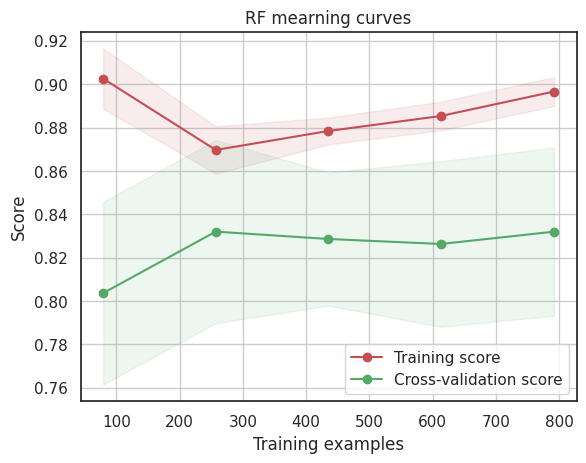

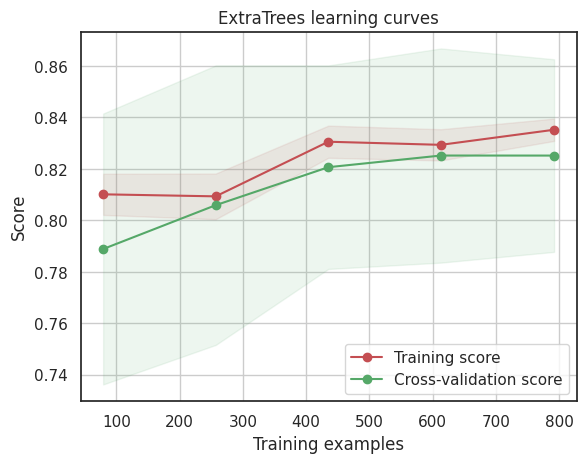

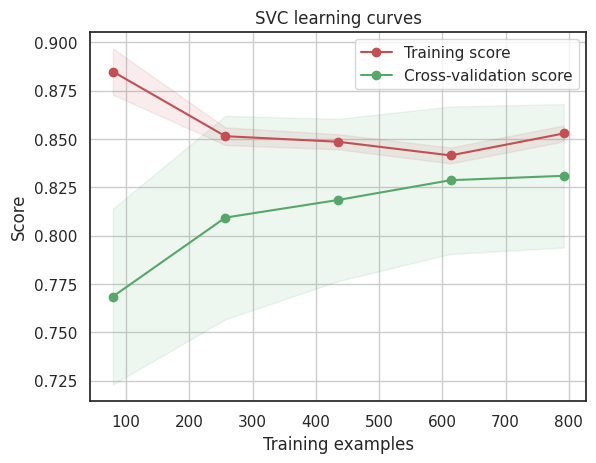

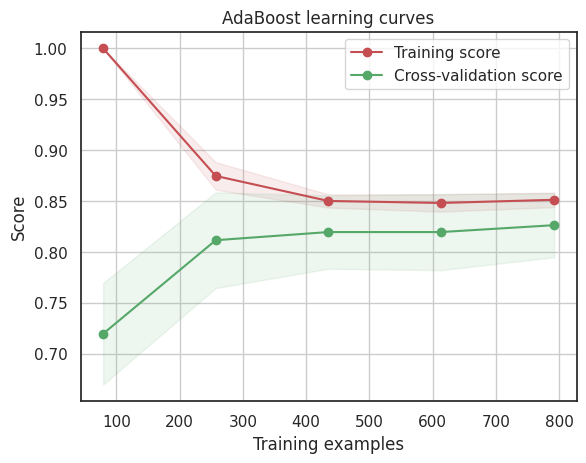

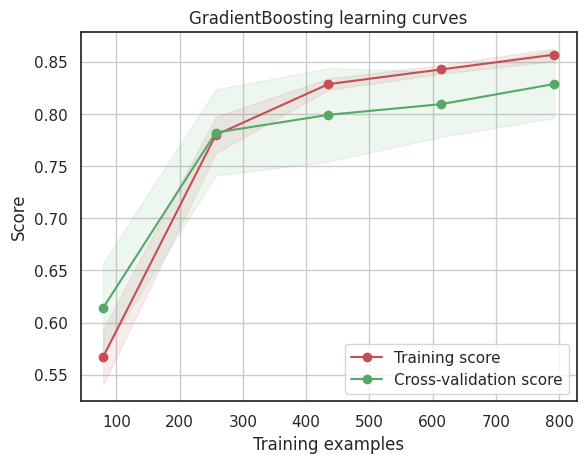

In [254]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)


# 6.1.4 Feature importance of tree based classifiers

## In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.



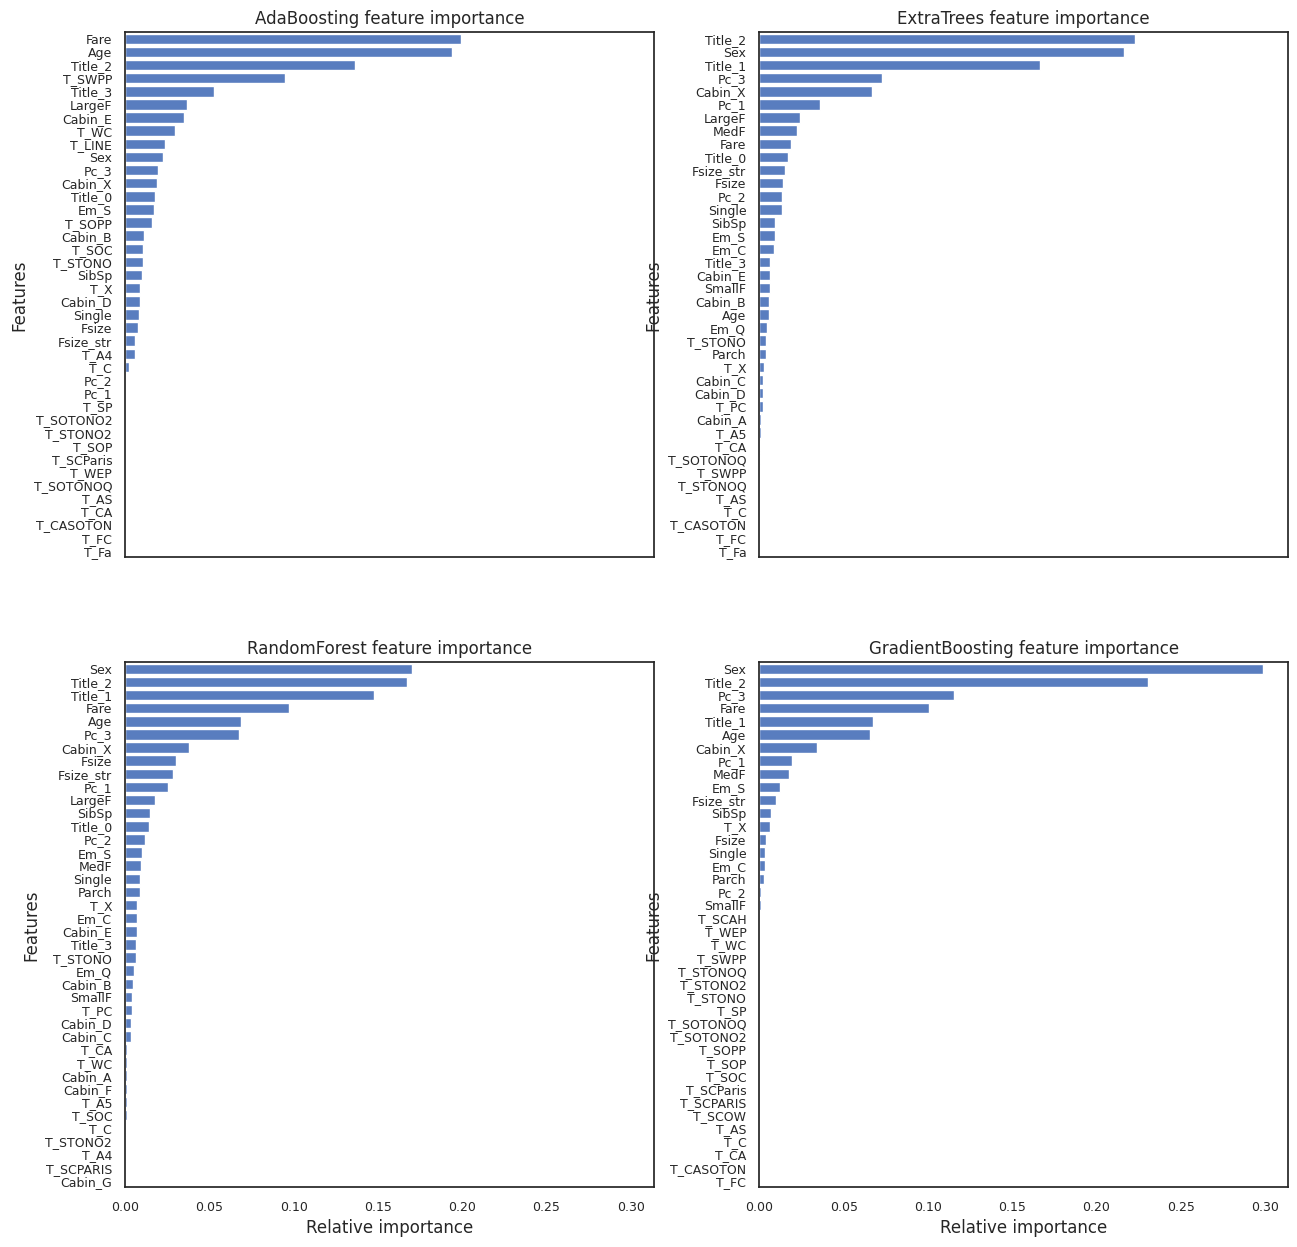

In [255]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

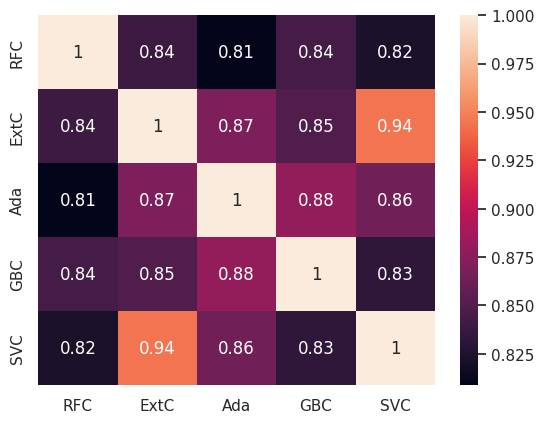

In [256]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

# 6.2 Ensemble modeling
## 6.2.1 Combining models
* I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

* I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [257]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [258]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)